In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:
root = '/home/amit/Documents/amitpython/DataSampleForExperiment1000/GRAPES/GRAPES'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)

class_names = train_data.classes

print(class_names)

print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')
print('There are {} batches in the train loader'.format(len(train_loader)))
print('There are {} batches in the test loader'.format(len(test_loader)))

['Grape_Black_Measles', 'Grape_Black_Rot', 'Grape_Healthy', 'Grape_Isariopsis']
Training images available: 800
Testing images available:  200
There are 160 batches in the train loader
There are 40 batches in the test loader


lAbels -> [2 2 3 2 0]
Label: [2 2 3 2 0]
Class: Grape_Healthy Grape_Healthy Grape_Isariopsis Grape_Healthy Grape_Black_Measles


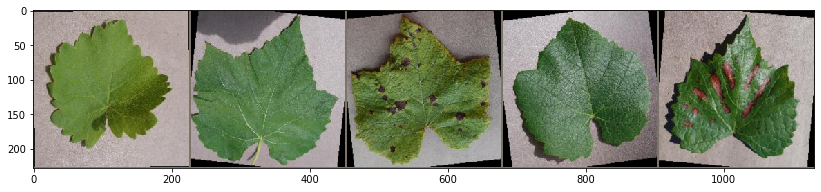

In [4]:
for images,labels in train_loader: 
    #print("IMg ->", images) #prints image tensors
    print("lAbels ->", labels.numpy())
    
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=9)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(14,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [5]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [6]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()  #loss_fn
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)

In [7]:
import time
start_time = time.time()

epochs = 8

train_losses = []
test_losses = []
train_correct = []  #train_accuracy
test_correct = []   # test_accuracy

for i in range(epochs):    #i is current epoch which is set to 0 at 1st
    trn_corr = 0
    tst_corr = 0
    batch_corr =0
    iterations = 0
    iter_loss = 0.0
    
    CNNmodel.train() 
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader): # X_train=inputs , y_train=labels
        
        # Apply the model          #X_train.shape --->[batch_size,3,224,224]
        y_pred = CNNmodel(X_train) #y_pred=output  #y_pred.shape --> [batch_size,4]
        loss = criterion(y_pred, y_train) # calculate loss betn (output i.e predicted) vs actual labels
        iter_loss += loss.item()   #save the loss in iteration_loss
 
        # Tally the number of correct predictions  i.e let's calculate accuracy
        predicted = torch.max(y_pred.data, 1)[1]  #y_pred=output, take the max of 1st dim i.e [batch_size,4(output)]
        #This returns 2 vals,1st is _, max real value and 2nd i.e predicted which is index.we want index 
        #the second field i.e predicted of themaximum value , not the 1stone i.e _ which we ignored here.
        batch_corr += (predicted == y_train).sum().item() #batch_corr = correct
        #(predicted == y_train) returns boolean, 1=euality, 0 not equal.
        
        
        trn_corr += batch_corr
        iterations += 1
        
        # Update parameters   
        optimizer.zero_grad()  #clear gradient buffer w <-- w- lr*gradient
        loss.backward()         # backpropgation
        optimizer.step()       # update weight

    #train_losses.append(loss)
    #print("Train Loss[] in Training ->", train_losses[-1])
    train_losses.append(iter_loss/iterations)
    ###print("Train Loss[] in Training ->", train_losses[-1])
    #train_correct.append(trn_corr)
    #print("Train correct[] in Training ->", train_correct[-1])
    train_correct.append((100 * batch_corr / len(train_data)))
    ###print("Train correct[] in Training ->", train_correct[-1])

    # Run the testing batches
    iterations = 0
    testing_loss = 0.0
    tst_corr = 0
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):  #X-test=input, y_test=labels
        
            # Apply the model
            y_val = CNNmodel(X_test)  #y_val = output

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum().item()  #tst_corr=correct
            iterations += 1
            loss = criterion(y_val, y_test)
    testing_loss += loss.item()
    
    #test_losses.append(loss)
    #print("Test Loss[] in Testing  ", test_losses[-1])
    test_losses.append(testing_loss/iterations)
    ###print("Test Loss[] in Testing ", test_losses[-1])
    #test_correct.append(tst_corr)
    #print("Test Accuracy[] in Testing ", test_correct[-1])
    test_correct.append((100 * tst_corr / len(test_data)))
    ###print("Test Accuracy[] in Testing ", test_correct[-1])
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(i+1, epochs, train_losses[-1], train_correct[-1], 
             test_losses[-1], test_correct[-1]))

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Epoch 1/8, Training Loss: 0.769, Training Accuracy: 66.750, Testing Loss: 0.035, Testing Acc: 77.000
Epoch 2/8, Training Loss: 0.415, Training Accuracy: 83.000, Testing Loss: 0.012, Testing Acc: 85.500
Epoch 3/8, Training Loss: 0.285, Training Accuracy: 88.625, Testing Loss: 0.007, Testing Acc: 84.500
Epoch 4/8, Training Loss: 0.238, Training Accuracy: 89.750, Testing Loss: 0.000, Testing Acc: 85.000
Epoch 5/8, Training Loss: 0.225, Training Accuracy: 91.250, Testing Loss: 0.009, Testing Acc: 87.000
Epoch 6/8, Training Loss: 0.161, Training Accuracy: 93.625, Testing Loss: 0.007, Testing Acc: 85.000
Epoch 7/8, Training Loss: 0.161, Training Accuracy: 93.750, Testing Loss: 0.002, Testing Acc: 89.500
Epoch 8/8, Training Loss: 0.162, Training Accuracy: 93.375, Testing Loss: 0.000, Testing Acc: 87.500

Duration: 443 seconds


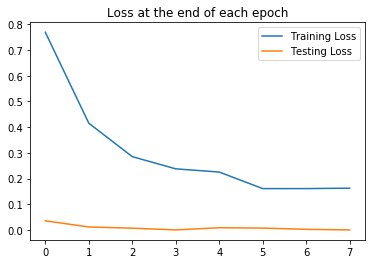

In [8]:
plt.plot(train_losses, label='Training Loss')   #Plotting the loss
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at the end of each epoch')
plt.legend();

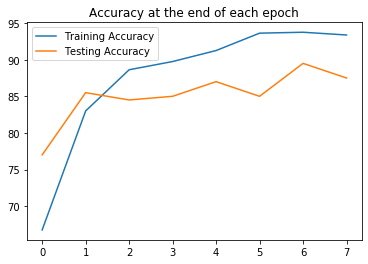

In [9]:
plt.plot(train_correct, label='Training Accuracy') #Plotting the accuracy
plt.plot(test_correct, label='Testing Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

label -> 0
Prediction is: 1
Actual is: 0
Correct 0


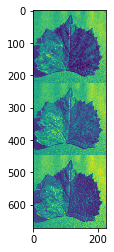

In [10]:
img = test_data[4][0].resize_((1, 3, 224, 224))   #(batch_size,channels,height,width)
correct=0
label = test_data[4][1]
print("label ->", label)
npimg = img.numpy() # img is your tensor
plt.imshow(img.reshape(-1,224))
#plt.imshow(np.transpose(npimg,(1, 2, 0)))
#plt.show()

CNNmodel.eval()
output = CNNmodel(img)
#_, predicted = torch.max(output,1)
predicted = torch.max(output.data, 1)[1] 
print("Prediction is: {}".format(predicted.item()))
print("Actual is: {}".format(label))
##Healthy 0 unhealthy1
correct += (predicted == label).sum()
print("Correct",correct.item())

In [11]:
for z in CNNmodel.parameters():
    print (z.numel())

162
6
864
16
5598720
120
10080
84
336
4


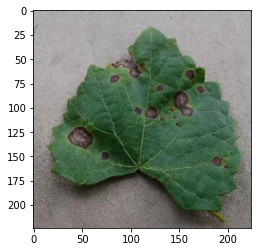

In [12]:
x = 74
im = inv_normalize(test_data[x][0])  #[0] -> image, [1]->label
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [13]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [14]:
# CNN Model Prediction:

CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 1 Grape_Black_Rot
